# Learning to Rank using LightGBM

This notebook demonstrates how to train a ranking model using [LightGBM](https://lightgbm.readthedocs.io/). 

This notebook is part of the [commerce product ranking sample app](https://github.com/vespa-engine/sample-apps/tree/master/commerce-product-ranking). 

Blog post series:

* [Improving Product Search with Learning to Rank - part one](https://blog.vespa.ai/improving-product-search-with-ltr/)
* [Improving Product Search with Learning to Rank - part two](https://blog.vespa.ai/improving-product-search-with-ltr-part-two/)
* [Improving Product Search with Learning to Rank - part three](https://blog.vespa.ai/improving-product-search-with-ltr-part-three/)

This work uses the largest product relevance dataset released by Amazon:

>We introduce the “Shopping Queries Data Set”, a large dataset of difficult search queries, released with the aim of fostering research in the area of semantic matching of queries and products. For each query, the dataset provides a list of up to 40 potentially relevant results, together with ESCI relevance judgements (Exact, Substitute, Complement, Irrelevant) indicating the relevance of the product to the query. Each query-product pair is accompanied by additional information. The dataset is multilingual, as it contains queries in English, Japanese, and Spanish.

The dataset is found at [amazon-science/esci-data](https://github.com/amazon-science/esci-data). 
The dataset and is released under the [Apache 2.0 license](https://github.com/amazon-science/esci-data/blob/main/LICENSE).



In [1]:
!pip3 install pandas lightgbm numpy


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [2]:
import pandas
import lightgbm 

Read the published training data. This dataframe contains scraped features from a running Vespa instance, using a  scrape rank-profile, returning calculated features using [match-features](https://docs.vespa.ai/en/reference/schema-reference.html#match-features).

In [3]:
train = pandas.read_parquet('https://data.vespa-cloud.com/sample-apps-data/product_ranking_train.parquet')

Sampling to view some features 

In [4]:
sample = train[['query', 'product_id','bm25(title)', 'bm25(description)', 'bi_encoder', 'esci_label']].sample(10)

In [5]:
sample

,query,product_id,bm25(title),bm25(description),bi_encoder,esci_label
197378,how universe works,B083XML9BC,0.000000,0.000000,0.442087,E
291713,peruvian fedora hat,B07TX28WD5,6.301285,8.807666,0.475027,S
262598,monster slim jim bulk,B08MC9KVDG,19.809741,0.000000,0.489854,E
263109,moped scooter gas moped,B094NX8D9F,28.225088,34.293286,0.447519,C
334172,seiko watch skx011j1,B00SC83784,14.132849,19.335447,0.477131,S
5143,/ to keep plastic from babies and not use this...,B08L7DNXT9,0.323208,11.934175,0.437449,I
169800,galaxy tab s-p580 sytlus,B07TS2N27S,8.957989,14.365782,0.474360,I
100670,car seat mirror without headrest,B07CZJXVD3,16.122397,22.590379,0.578379,E
124862,cup holder hook for knee scooter basket,B01M16W8UU,8.221917,8.765739,0.437110,I
149858,envy magnetic lashes,B0057XP7VC,8.789868,0.000000,0.494379,E


## Feature exploration 

The DataFrame contains all the train examples and each row have a set of features produced by Vespa. These features have been computed in Vespa and scraped using a simple routine that scrapes features for a set of query, product pairs. 

The following plots several features versus the target label 

- BM25(title) - standard bm25 over the title
- bi_encoder - the dense semantic model score 
- cross_encoder - the cross-encoder semantic model  

<AxesSubplot: xlabel='esci_label', ylabel='bm25(title)'>

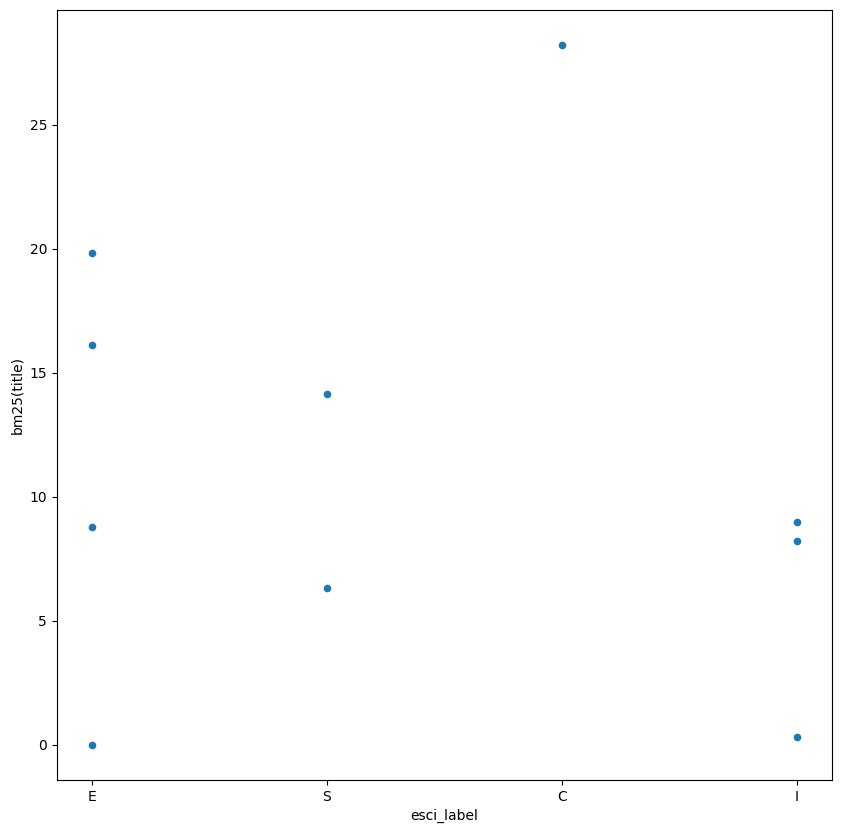

In [6]:
sample.plot(x='esci_label',y='bm25(title)',kind='scatter',figsize=(10,10))

<AxesSubplot: xlabel='esci_label', ylabel='bi_encoder'>

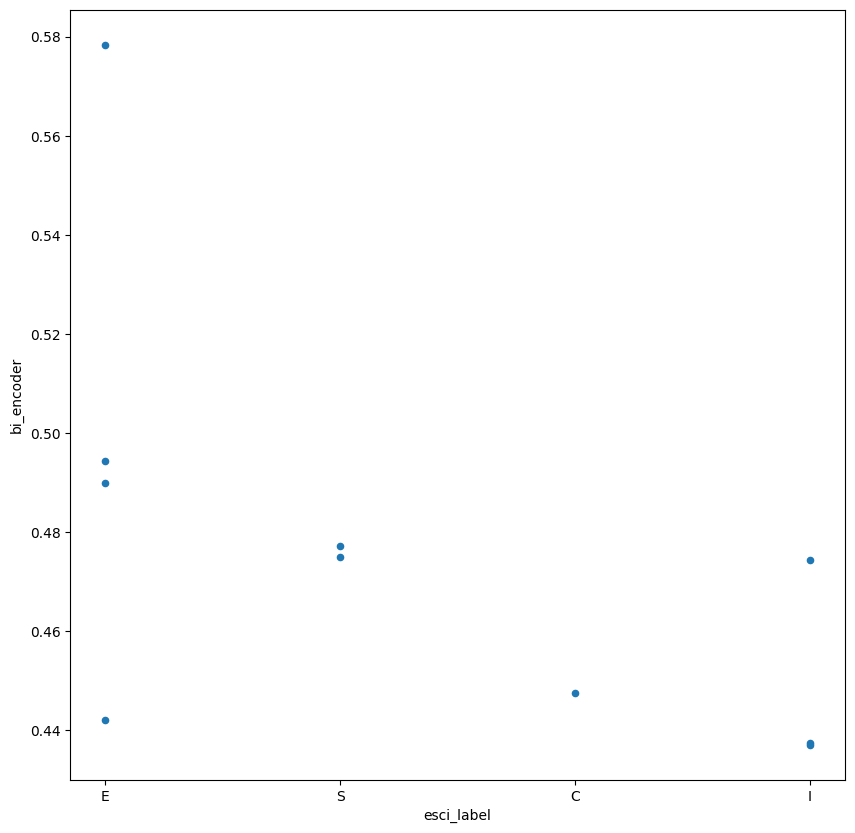

In [7]:
sample.plot(x='esci_label',y='bi_encoder',kind='scatter',figsize=(10,10))

## Dataset and split processing
Convert the dataset's textual labels Exact, Substitute, Complement, Irrelevant to numeric labels. LightGBM only supports integer labels, but we can map from integer labels to label gain. 

In [8]:
esci_2_numeric = {
        'E' : 4,
        'S' : 3,
        'C' : 2,
        'I' : 1,
}
train['label'] = train['esci_label'].apply(lambda esci_label: esci_2_numeric[esci_label])

We create a dev split from the original train split (80:20 split)

In [9]:
train_queries = pandas.read_parquet('https://data.vespa-cloud.com/sample-apps-data/train_query_ids.parquet')['query_id'].unique()
dev_queries = pandas.read_parquet('https://data.vespa-cloud.com/sample-apps-data/dev_query_ids.parquet')['query_id'].unique()

We filter so that we end up with two splits or the original train dataset. This way we can evaluate performance on the dev set and we avoid tuning hyperparameters based on observed test set performance. 

In [10]:
df_train = train[train['query_id'].isin(train_queries)]
df_dev = train[train['query_id'].isin(dev_queries)]

We need to group by query_id so that LightGBM knows which products belongs to which query.

In [11]:
train_query_groups=df_train['query_id'].value_counts().sort_index().values
dev_query_groups=df_dev['query_id'].value_counts().sort_index().values

The label we want to predict  

In [12]:
train_target = df_train['label'].values
dev_target = df_dev['label'].values

Drop columns that we don't need during training, after this we are left with just the pure features

In [13]:
drop_fields = ['example_id', 'query', 'query_id', 'product_id', 'product_locale', 'esci_label', 'small_version', 'large_version', 'split', 'label']


In [14]:
df_dev = df_dev.drop(drop_fields, axis=1)
df_train = df_train.drop(drop_fields, axis=1)

In this case, we choose a subset of features to train with. Deleting this cell, trains on all available features. 

In [15]:
df_dev = df_dev[['bi_encoder', 'bm25(title)', 'bm25(description)', 'bm25(bullets)', 'nativeRank(title)']]
df_train = df_train[['bi_encoder', 'bm25(title)', 'bm25(description)', 'bm25(bullets)', 'nativeRank(title)']]

## Prepare for training the model
Create lightgbm.Dataset of the train and dev splits. Please notice the group parameter so that the model training knows which data points belongs to which query.

In [16]:
train_ds = lightgbm.Dataset(df_train, train_target, group=train_query_groups)
dev_ds = lightgbm.Dataset(df_dev, dev_target, group=dev_query_groups)

## Model Training

Configure hyperparameters. 
 
Note the **label_gain** parameter, this array is used to get the gain for each label, by label_gain[label]. 
We have 4 labels (1,2,3,4), but the array needs to be of length 5 because of the label lookup. 

In this case label 1 (irrelevant) has 0 gain, label 2 (Complement) has gain 0.01, label 3 (Subsitute) has gain 0.1, and finally label 4 has gain 1. 

We use **eval_at** 200, to ensure that we measure NDCG across all products for a query, and not a cutoff at a certain level (e.g NDCG@10). 

In [17]:
params = {
  'objective': 'lambdarank',
  'metric': 'ndcg', 
  'label_gain' : [0, 0, 0.01, 0.1, 1],
  'eta':0.05,
  'eval_at': '200', 
  'num_leaves': 31,
  'early_stopping_round': 100,
  'min_data_in_leaf': 40,
  'feature_fraction':0.6,
  'feature_fraction_bynode':0.8
}

Train the model, output's NDCG for both the train and our dev split. We use `early_stopping_round=100` which will stop training if the validation dataset accuracy does not improve.  

In [18]:
model = lightgbm.train(params, train_ds , num_boost_round=2000, valid_sets=[train_ds, dev_ds])

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 335674, number of used features: 5
[1]	training's ndcg@200: 0.832641	valid_1's ndcg@200: 0.823551
Training until validation scores don't improve for 100 rounds
[2]	training's ndcg@200: 0.854079	valid_1's ndcg@200: 0.84025
[3]	training's ndcg@200: 0.854252	valid_1's ndcg@200: 0.841185
[4]	training's ndcg@200: 0.852533	valid_1's ndcg@200: 0.839668
[5]	training's ndcg@200: 0.850882	valid_1's ndcg@200: 0.839149
[6]	training's ndcg@200: 0.855214	valid_1's ndcg@200: 0.84187
[7]	training's ndcg@200: 0.853938	valid_1's ndcg@200: 0.841028
[8]	training's ndcg@200: 0.856267	valid_1's ndcg@200: 0.843034
[9]	training's ndcg@200: 0.855599	valid_1's ndcg@200: 0.842338
[10]	training's ndcg@200: 0.857227	valid_1's ndcg@200: 0.843116
[11]	training's n

[124]	training's ndcg@200: 0.867534	valid_1's ndcg@200: 0.844826
[125]	training's ndcg@200: 0.86759	valid_1's ndcg@200: 0.844877
[126]	training's ndcg@200: 0.867592	valid_1's ndcg@200: 0.844844
[127]	training's ndcg@200: 0.867685	valid_1's ndcg@200: 0.84489
[128]	training's ndcg@200: 0.867739	valid_1's ndcg@200: 0.844981
[129]	training's ndcg@200: 0.867765	valid_1's ndcg@200: 0.84499
[130]	training's ndcg@200: 0.867817	valid_1's ndcg@200: 0.844851
[131]	training's ndcg@200: 0.867903	valid_1's ndcg@200: 0.844935
[132]	training's ndcg@200: 0.867973	valid_1's ndcg@200: 0.844915
[133]	training's ndcg@200: 0.868064	valid_1's ndcg@200: 0.845033
[134]	training's ndcg@200: 0.868123	valid_1's ndcg@200: 0.844994
[135]	training's ndcg@200: 0.868106	valid_1's ndcg@200: 0.844935
[136]	training's ndcg@200: 0.868161	valid_1's ndcg@200: 0.845037
[137]	training's ndcg@200: 0.868128	valid_1's ndcg@200: 0.844928
[138]	training's ndcg@200: 0.868186	valid_1's ndcg@200: 0.844921
[139]	training's ndcg@200: 0

[251]	training's ndcg@200: 0.872521	valid_1's ndcg@200: 0.844981
[252]	training's ndcg@200: 0.872515	valid_1's ndcg@200: 0.844989
[253]	training's ndcg@200: 0.872582	valid_1's ndcg@200: 0.844931
[254]	training's ndcg@200: 0.872571	valid_1's ndcg@200: 0.844916
[255]	training's ndcg@200: 0.872621	valid_1's ndcg@200: 0.8449
[256]	training's ndcg@200: 0.872645	valid_1's ndcg@200: 0.844844
[257]	training's ndcg@200: 0.872697	valid_1's ndcg@200: 0.844876
[258]	training's ndcg@200: 0.872697	valid_1's ndcg@200: 0.844723
[259]	training's ndcg@200: 0.872723	valid_1's ndcg@200: 0.844768
[260]	training's ndcg@200: 0.872756	valid_1's ndcg@200: 0.844777
[261]	training's ndcg@200: 0.87279	valid_1's ndcg@200: 0.844743
[262]	training's ndcg@200: 0.872821	valid_1's ndcg@200: 0.844694
[263]	training's ndcg@200: 0.872857	valid_1's ndcg@200: 0.844848
[264]	training's ndcg@200: 0.872907	valid_1's ndcg@200: 0.844842
[265]	training's ndcg@200: 0.872946	valid_1's ndcg@200: 0.844804
[266]	training's ndcg@200: 0

Plot feature importance 

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

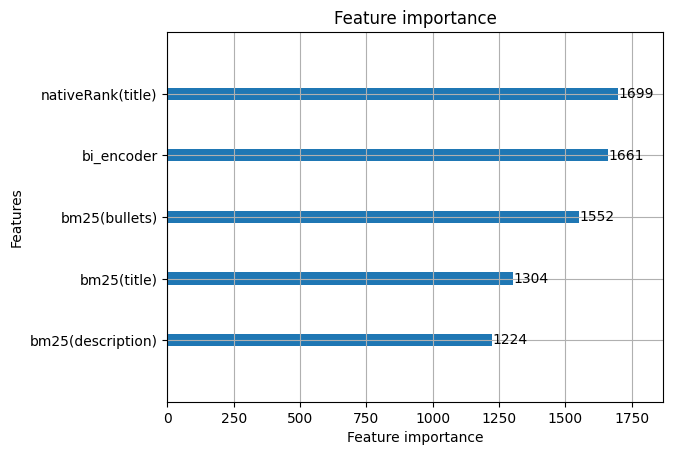

In [19]:
lightgbm.plot_importance(model, max_num_features=10, importance_type="split")

## Export model for serving in Vespa 

See [importing-lightgbm-models](https://docs.vespa.ai/en/lightgbm#importing-lightgbm-models) for how to import the exported JSON file into Vespa for serving. Since we used a DataFrame with column names as input, the column names are used as feature names. 

In [20]:
model_dump = model.dump_model()

In [21]:
import json
with open('product_ranker_simple_lightgbm.json','w') as fp:
    fp.write(json.dumps(model_dump))

Place the exported `product_ranker_simple.json` file in the `models` directory in the Vespa application package and configure the rank-profile:

<pre>
rank-profile gbdt-small {
  first-phase {
    expression: lightgbm("product_ranker_simple_lightgbm.json")
  }
}
</pre>